In [1]:
include("./src/WatchFish.jl")
using .WatchFish
using BenchmarkTools

In [2]:
m = CountingExperiment()

add_component!(m, "Signal", 20.0)
add_component!(m, "Bkg 1", 30.0; σ=0.1)
add_component!(m, "Bkg 2", 40.0; σ=45.0)
add_component!(m, "Bkg 3", 12.0; σ=12.0)

set_counts!(m, 100)

results = minimize!(m)

compute_profiled_uncertainties!(results; σ=1)
pretty_results(results)

#x, y = profile!("Bkg 2", results)
#plt.plot(x, y)
#plt.show()

seval = "lognormal(x[1],30.0,0.1,) +lognormal(x[2],40.0,45.0,) +lognormal(x[3],12.0,12.0,) +logpoisson(100.0,x[4],x[1],x[2],x[3],) "


,Name,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64
1,Bkg 1,30.0,30.0,30.0
2,Bkg 2,40.0,1.0,67.0
3,Bkg 3,12.0,1.0,23.0
4,Signal,18.0,-23.0,59.0


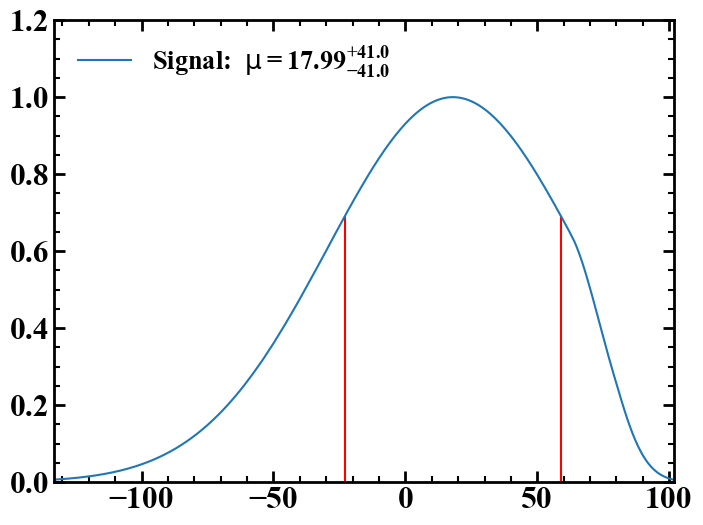

(y[x .>= low])[1] = 0.6903020945443831


findfont: Font family ['Nimbus Roman Italic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


In [3]:
using PyPlot
plt.style.use("watchman")

hs = x -> x >= 0 ? 1 : 0
#profile!("Signal", results; prior=nothing)
#uncertainty!("Signal", results )

interval_plot(results, "Signal")
plt.savefig("profile.svg")
plt.show()

In [ ]:
# We could build a special Counting model in
# src/models/ <= Predefined models
s    = Parameter("Signal"; init=2.0)
b    = Parameter("Bkg1"; init=10.0)
mb   = Parameter("bhat"; init=10.0, constant=true )
sb   = Parameter("bvar"; init=2.0, constant=true  )
data = Parameter("data"; init=16.0, constant=true )

oblist = Array{NLogPDF}(undef, 0)
push!(oblist, NLogPDF("lognormal", b, mb, sb) )
push!(oblist, NLogPDF("logpoisson", data, s, b))

nll = NLogLikelihood(oblist)
#@show nll.variableList
@show nll.numparams

#@benchmark nll.objective([10.0, 6.0])

optimize_model!(nll)

In [ ]:
# shape, 2 bkg + signal
using Random
using DataFrames

add_dataset(:data, DataFrame( energy=( randn(1000).*3.5 .+ 20.0 )) )

# Todo, add this as return to add_dataset, and put in macro
data = WatchFish.data

@show size(data, 1)

@addfunction gausfit(μ,σ) = begin
    sum( -log.( exp.(-( data.energy.-μ).^2/2/σ^2)/sqrt(2π*σ^2) ) )
end

pauli = Parameter("pauli"; init=15.0)
tommy = Parameter("tommy"; init=2.5)
# sofy = Dataset("j")
norm = Parameter("N"; init=10.0)
#observation_count = Parameter("obs"; init=Float64( size(data,1) ), constant=true )
observation_count = Parameter("obs"; init=1000.0, constant=true )
extend = NLogPDF("logpoisson", observation_count, norm)

pdf = NLogPDF("gausfit", pauli, tommy)
nll = NLogLikelihood([pdf, extend])

#nll.objective([20.0, 3.5])
_, bfit, _ = optimize_model!(nll)



In [ ]:
using PyPlot

@show bfit

x = collect(0:1:50)
plt.hist(data.energy, bins=x)
plt.show()

In [ ]:
## Lets fit the normalization, given we know the shapes
df1 = DataFrame(energy=( randn(10).*2.0 .+ 20.0 ) )
append!(df1, DataFrame(energy=( randn(20).*5.0 .+ 23.0 ) ))
append!(df1, DataFrame(energy=( randn(5).*1.0 .+ 18.0 ) ))

add_dataset(:tri, df1 )
tri = WatchFish.tri

@addfunction shape(μ, σ) = @. exp(-(tri.energy-μ)^2/2/σ^2)/sqrt(2π*σ^2)
#@addfunction shape(μ, σ) = @. tri.energy*0 + 1

## Free parameters
s  = Parameter("signal"; init=1.0)
b1 = Parameter("bkg1"; init=1.0)
b2 = Parameter("bkg2"; init=1.0)
## Data counts
observation_count = Parameter("obs"; init=Float64( size(tri,1) ), constant=true )
## Known Means
sm = Parameter("Signal Mean"; init=20.0, constant=true)
bm1 = Parameter("Bkg1 Mean"; init=23.0, constant=true)
bm2 = Parameter("Bkg2 Mean"; init=18.0, constant=true)
## Known Sigma
ss = Parameter("Signal Sig"; init=2.0, constant=true)
bs1 = Parameter("Bkg1 Sig"; init=5.0, constant=true)
bs2 = Parameter("Bkg2 Sig"; init=1.0, constant=true)
## Build the PDF functions
@addfunction spectralpdf(b1, b2, b3, m1, m2, m3, s1, s2, s3) = begin
    -sum(log.( b1*shape(m1, s1) .+ b2*shape(m2, s2) .+ b3*shape(m3, s3) ))
end
@addfunction logextend(n, x...) = begin
    λ = sum([x...])
    λ + n*log(n) - n
end
## Construct NLL
ob1 = NLogPDF("spectralpdf", s, b1, b2, sm, bm1, bm2, ss, bs1, bs2)
ob2 = NLogPDF("logextend", observation_count, s, b1, b2)
nll = NLogLikelihood([ob1, ob2])

_, bfit, _ = optimize_model!(nll)

@show bfit
#@benchmark nll.objective(bfit)
#plt.hist(df1.energy, bins=collect(1:1:30))
#@show WatchFish.spectralpdf(1.0, 2.0, 3.0,1.0, 2.0, 3.0,1.0, 2.0, 3.0)
#@show log.(2*WatchFish.shape(1.0, 1.0) .+ 3*WatchFish.shape(1.0, 1.0))


In [ ]:
## NICE; Lets hold and come back